In [74]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [75]:
import logging

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from src.data.database_manager import DatabaseManager
from src.features.scaling import scale_min_max
from src.log_config import configure_logging
from src.plots.averages import (
    add_ci_to_averages,
    average_over_stimulus_seeds,
    calculate_max_crosscorr_lag_over_averages,
    plot_averages_with_ci,
)

configure_logging(
    ignore_libs=("Comm", "bokeh", "tornado", "matplotlib"),
)

pl.Config.set_tbl_rows(12)  # for 12 seeds
hv.output(widget_location="bottom", size=150)

In [76]:
db = DatabaseManager()

In [77]:
# Get data
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )
df

trial_id,trial_number,participant_id,timestamp,temperature,rating,eda_raw,eda_tonic,eda_phasic,ppg_raw,ppg_ibi_shimmer,heartrate,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,pupil_mean_tonic,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
23,1,3,184809.3687,0.0,0.93625,3.855469,4.417003,-0.561535,1318.503562,-2.847329,69.330443,4.021351,4.492471,4.491222,4.022056,4.256639,4.309533,0.00008,0.00185,0.00251,0.0033,0.01223,0.0,658,1,0,0,111,111,67,0,0
23,1,3,184909.3687,0.000081,0.93625,3.87526,4.434407,-0.559147,1427.801949,-0.98335,69.314627,4.041885,4.502159,4.50269,4.0408,4.271745,4.316037,0.000037,0.000965,0.001661,0.001437,0.006411,100.0,658,1,0,0,111,111,67,0,0
23,1,3,185009.3687,0.000325,0.93625,3.897236,4.453884,-0.556648,1488.690007,0.783387,69.24965,4.059964,4.527155,4.527178,4.061328,4.294253,4.322598,0.000047,0.000486,0.001811,0.000719,0.006277,200.0,658,1,0,0,111,111,67,0,0
23,1,3,185109.3687,0.000887,0.93625,3.916581,4.472846,-0.556266,1459.485729,-5.07083,69.105468,4.087014,4.564178,4.563636,4.085616,4.324626,4.328764,0.00004,0.000528,0.000901,0.002076,0.006666,300.0,658,1,0,0,111,111,67,0,0
23,1,3,185209.3687,0.001743,0.93625,3.940876,4.489759,-0.548884,1433.276657,3.82947,68.885211,4.127938,4.581748,4.582575,4.12897,4.355773,4.334565,0.000049,0.000496,0.000628,0.001315,0.007096,400.0,658,1,0,0,111,111,67,0,0
23,1,3,185309.3687,0.0029,0.93625,3.973437,4.507247,-0.53381,1409.203397,-5.340423,68.558235,4.185911,4.589515,4.58934,4.186352,4.387846,4.339762,0.00001,0.000251,0.000542,0.000527,0.003068,500.0,658,1,0,0,111,111,67,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
513,12,50,2.6956e6,0.031312,0.0,26.688608,26.716225,0.003169,1323.813266,-5.036073,59.279672,5.166699,4.766597,4.768156,5.167254,4.967705,5.180142,0.000465,0.001124,0.007081,0.00022,0.004168,179500.0,806,1,2565,1539,0,0,0,0,0
513,12,50,2.6957e6,0.030874,0.0,26.68499,26.716212,0.000389,1244.871959,44.337204,58.673362,5.026438,4.683481,4.690238,5.025632,4.857935,5.174284,0.000698,0.000846,0.007044,0.000348,0.004289,179600.0,806,1,2565,1539,0,0,0,0,0


In [78]:
signals = [
    "temperature",
    "rating",
    "heartrate",
    "pupil_mean",
    "pupil_mean_tonic",
    "eda_tonic",
    "eda_phasic",
]

## Single trial

In [79]:
scale_min_max(df).hvplot(x="timestamp", y=signals, groupby="trial_id", muted_alpha=0)

BokehModel(combine_events=True, render_bundle={'docs_json': {'a119969a-4904-4715-ab3e-01b512afaad1': {'version…

## Averaged trials over stimulus seeds with confidence intervals

In [80]:
averages = average_over_stimulus_seeds(df, signals)
conf = add_ci_to_averages(
    averages,
    signals,
    confidence_level=0.95,
)
plot_averages_with_ci(
    conf,
    signals,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'372cfc51-fd73-4b40-a65e-a09d1eaf9d1a': {'version…

## Cross correlation lag

In [85]:
for sig in signals:
    if sig == "temperature":
        continue
    col1 = "avg_temperature"
    col2 = f"avg_{sig}"
    calculate_max_crosscorr_lag_over_averages(
        averages,
        col1,
        col2,
        fs=10,
    )

14:59:04 | INFO    | averages | avg_temperature : avg_rating | mean lag: -0.64, std lag: 0.45
14:59:04 | INFO    | averages | avg_temperature : avg_heartrate | mean lag: 0.27, std lag: 2.10
14:59:04 | INFO    | averages | avg_temperature : avg_pupil_mean | mean lag: 1.31, std lag: 0.71
14:59:04 | INFO    | averages | avg_temperature : avg_pupil_mean_tonic | mean lag: 1.33, std lag: 0.72
14:59:04 | INFO    | averages | avg_temperature : avg_eda_tonic | mean lag: -0.11, std lag: 0.81
14:59:04 | INFO    | averages | avg_temperature : avg_eda_phasic | mean lag: -2.48, std lag: 0.90


14:58:44 | INFO    | averages | avg_temperature : avg_rating | mean lag: -0.64, std lag: 0.45


stimulus_seed,lag
u16,f64
133,0.1
243,-0.8
265,-1.0
396,-0.9
467,-0.9
658,-0.1
681,-0.8
743,0.2
806,-1.2


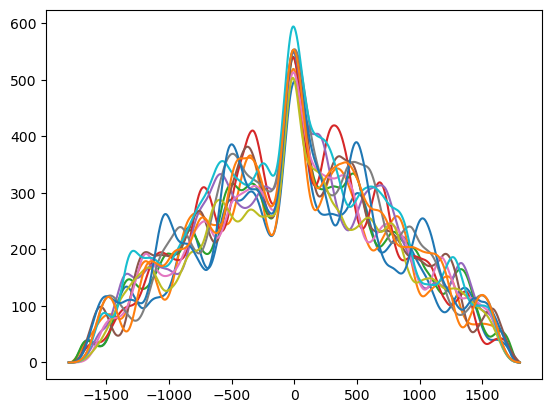

In [84]:
calculate_max_crosscorr_lag_over_averages(
    averages,
    "avg_temperature",
    "avg_rating",
    fs=10,
    plot=True,
)